# Monod Example
Author(s): Paul Miles | Date: June 18, 2018

__Return to [Index](https://nbviewer.jupyter.org/github/prmiles/notebooks/blob/master/pymcmcstat/index.ipynb)__

This example is from P.M. Berthouex and L.C. Brown: "Statistics for Environmental Engineers", CRC Press, 2002.

We fit the Monod model
$$y(t;q) = q_1 \frac{t}{q_2 + t} + \epsilon, \quad \epsilon\sim N(0,\sigma^2), \quad q = [\mu_{max}, K_x]$$
to observations:

| x (mg/L COD) | y (1/h) |
|----------|:---------|
| 28 | 0.053|
| 55 | 0.060|
| 83 | 0.112|
| 110| 0.105|
| 138| 0.099|
| 225| 0.122|
| 375| 0.125|

# Import required packages

In [1]:
import numpy as np
import scipy.optimize
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt

# Initialize MCMC object, and create data structure

In [2]:
# Initialize MCMC object
mcstat = MCMC()

# Next, create a data structure for the observations and control
# variables. Typically one could make a structure |data| that
# contains fields |xdata| and |ydata|.
ndp = 7
x = np.array([28,    55,    83,    110,   138,   225,   375])   # (mg / L COD)
x = x.reshape(ndp,1) # enforce column vector
y = np.array([0.053, 0.060, 0.112, 0.105, 0.099, 0.122, 0.125]) # (1 / h)
y = y.reshape(ndp,1) # enforce column vector

# data structure 
mcstat.data.add_data_set(x,y)

# Define model and sum-of-squares function
For the MCMC run we need the sum of squares function. For the plots we shall also need a function that returns the model. Both the model and the sum of squares functions are easy to write as follows

In [3]:
def modelfun(x, theta):
    return theta[0]*x/(theta[1] + x)

def ssfun(theta,data):
    res = data.ydata[0] - modelfun(data.xdata[0], theta)
    return (res ** 2).sum(axis = 0)

# Perform initial optimization study for estimating the error variance and computing the covariance matrix
We define a residuals function and minimize it using scipy's optimize least-squares.

In [4]:
def residuals(p, x, y):
    return y - modelfun(x, p)

theta0, ssmin = scipy.optimize.leastsq(residuals, x0 = [0.15, 100], args=(mcstat.data.xdata[0].reshape(ndp,), mcstat.data.ydata[0].reshape(ndp,)))
n = mcstat.data.n[0] # number of data points in model
p = len(theta0); # number of model parameters (dof)
ssmin = ssfun(theta0, mcstat.data) # calculate the sum-of-squares error
mse = ssmin/(n-p) # estimate for the error variance

The Jacobian matrix of the model function is easy to calculate so we use it to produce estimate of the covariance of theta. This can be used as the initial proposal covariance for the MCMC simulation by assigning it to `qcov` in the `simulation_options` (see below).

In [5]:
J = np.array([[x/(theta0[1]+x)], [-theta0[0]*x/(theta0[1]+x)**2]])
J = J.transpose()
J = J.reshape(n,p)
tcov = np.linalg.inv(np.dot(J.transpose(),J))*mse
print('tcov = {}'.format(tcov))

tcov = [[2.44707212e-04 2.50115314e-01]
 [2.50115314e-01 3.20837579e+02]]


# Setup parameters, model settings, and simulation options
- Parameters: 
    - $\mu_{max} \in [0,\infty]$
    - $K_x \in [0,\infty]$
- Model Settings: 
    - $\sigma^2_0 = 0.01^2$ (initial error variance)
    - sum-of-squares function defined above
- Simulation Options:
    - Number of simulation: 5000
    - Update error variance
    - Initial covariance matrix from least squares optimization

In [6]:
mcstat.parameters.add_model_parameter(name = '$\mu_{max}$', theta0 = theta0[0], minimum = 0)
mcstat.parameters.add_model_parameter(name = '$K_x$', theta0 = theta0[1], minimum = 0)

In [7]:
mcstat.simulation_options.define_simulation_options(nsimu = int(5.0e3), updatesigma = 1, qcov = tcov)
mcstat.model_settings.define_model_settings(sos_function = ssfun, sigma2 = 0.01**2)

# Run Simulation

In [8]:
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
$\mu_{max}$:      0.15 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
     $K_x$:     49.05 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 0.9 sec

# Extract results:
- Display chain statistics

In [9]:
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names

mcstat.chainstats(chain, results)


---------------------
name      :       mean        std     MC_err        tau     geweke
$\mu_{max}$:     0.1563     0.0243     0.0012    14.0126     0.9378
$K_x$     :    65.9592    34.0110     1.8133    16.1137     0.8870
---------------------


## Plot mean model response and compare with data

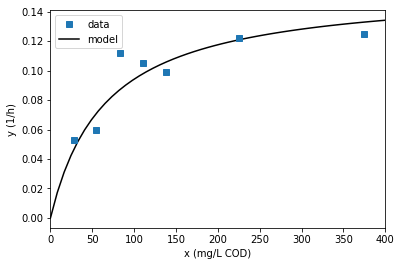

In [10]:
# A point estimate of the model parameters can be calculated from the
# mean of the |chain|. Here we plot the fitted model using the
# posterior means of the parameters.
xmod = np.linspace(1e-4,400)
plt.figure(1)
hmodel, = plt.plot(xmod,modelfun(xmod,np.mean(chain, 0)),'-k', label = 'model')
hdata, = plt.plot(mcstat.data.xdata[0], mcstat.data.ydata[0], 's', label = 'data');
plt.xlim([0, 400])
plt.xlabel('x (mg/L COD)')
plt.ylabel('y (1/h)')
plt.legend(handles = [hdata, hmodel]);

## Visualize parameter chains and pairwise correlation:
- `plot_chain_panel`: plots the sampling history of the simulation
- `plot_pairwise_correlation_panel`: chains plotted against each other

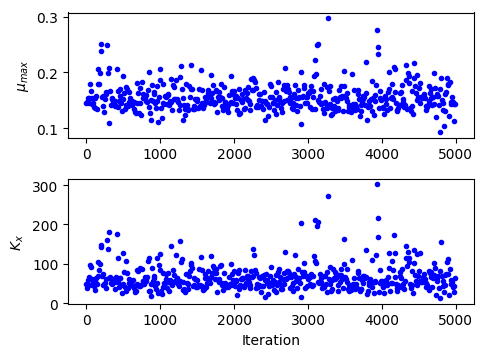

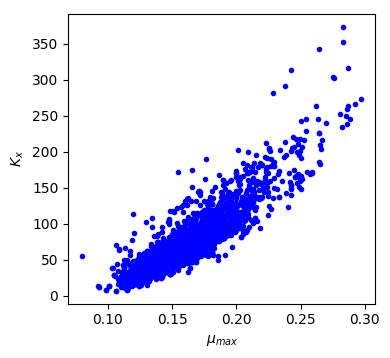

In [11]:
# plot chain panel
mcstat.mcmcplot.plot_chain_panel(chain, names)
plt.savefig('monod_chain_panel.eps', format = 'eps', dpi = 500, bbox_inches='tight')
# The |'pairs'| options makes pairwise scatterplots of the columns of
# the |chain|.
mcstat.mcmcplot.plot_pairwise_correlation_panel(chain, names, figsizeinches=(4,4));
plt.savefig('monod_pairwise.eps', format = 'eps', dpi = 500, bbox_inches='tight')

## Generate credible intervals
Instead of just a point estimate of the fit, we should also study the predictive posterior distribution of the model. We can calculate the model fit for a randomly selected subset of the chain and calculate the predictive envelope of the model. The grey areas in the plot correspond to 50%, 90%, 95%, and 99% posterior regions.

Generating credible/prediction intervals:


Interval generation complete



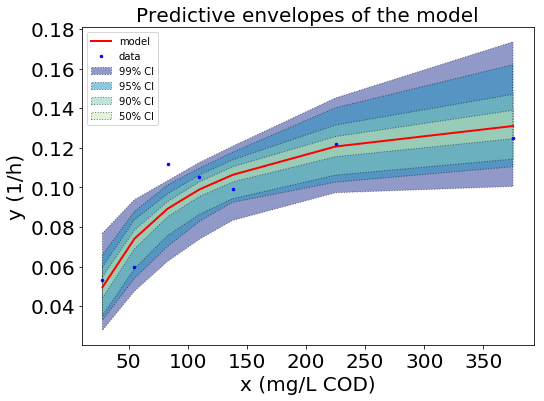

In [12]:
def predmodelfun(data, theta):
    return modelfun(data.xdata[0], theta)

mcstat.PI.setup_prediction_interval_calculation(results = results, data = mcstat.data, 
                                                modelfunction = predmodelfun)
mcstat.PI.generate_prediction_intervals(nsample = 500, calc_pred_int = 'off')
# plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata = True)
plt.xlabel('x (mg/L COD)',Fontsize=20)
plt.xticks(Fontsize=20)
plt.ylabel('y (1/h)',Fontsize=20)
plt.yticks(Fontsize=20)
plt.title('Predictive envelopes of the model',Fontsize=20)
plt.savefig('monod_ci.png', format = 'png', dpi = 500, bbox_inches='tight')